In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import libraries required
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import random
import os
import zipfile
from shutil import copyfile

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
import torchvision
import torchvision.transforms as tvt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#create dataset and dataloader
class CelebDataset(Dataset):
    
    #intializations
    def __init__(self, root_dir, transform = None):
        super().__init__()
        self.root_dir = root_dir
        self.image_paths = []
        self.transform = transform

        #add image paths and corresponding class as a label
        for img_name in os.listdir(root_dir):
          self.image_paths.append(os.path.join(root_dir,img_name))

    #compute length of dataset
    def __len__(self):
        return len(self.image_paths)

    #apply transformations for the image chosen by index
    def __getitem__(self, index):
        img = Image.open(self.image_paths[index]).convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img

In [ ]:
batch_size = 32
num_workers = 2

In [ ]:
#load data and create dataloader (train and eval)
transform = tvt.Compose([tvt.Resize((64, 64)), tvt.ToTensor(), tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_path = '/content/drive/MyDrive/Purdue/SML/data/train'
train_dataset = CelebDataset(train_path, transform = transform)
train_data_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=num_workers)

#check for the data length
print(len(train_dataset))

20004


In [ ]:
eval_path = '/content/drive/MyDrive/Purdue/SML/data/test'
eval_dataset = CelebDataset(eval_path, transform = transform)
eval_data_loader = DataLoader(eval_dataset, batch_size = batch_size, shuffle = True, num_workers=num_workers)
print(len(eval_dataset))

5004


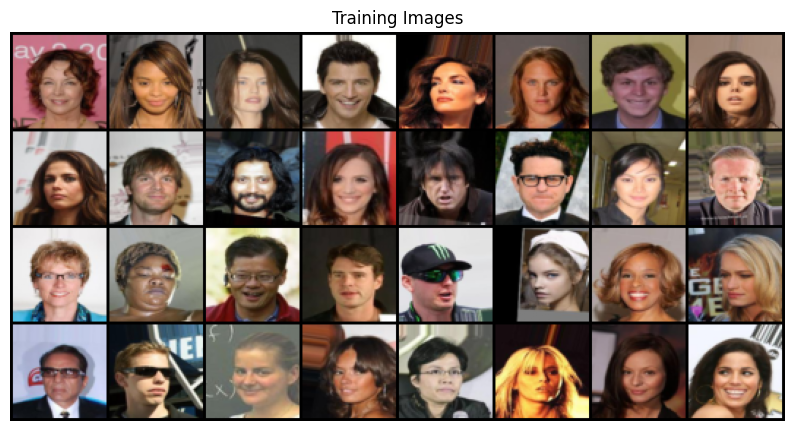

In [ ]:
#plot images of a batch to check dataloader
images = next(iter(train_data_loader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:], padding=2, normalize=True),(1,2,0)));

In [ ]:
#initialize weights
def weights_init(m):        
    """
    Uses the DCGAN initializations for the weights
    """
    classname = m.__class__.__name__     
    if classname.find('Conv') != -1:         
        nn.init.normal_(m.weight.data, 0.0, 0.02)      
    elif classname.find('BatchNorm') != -1:         
        nn.init.normal_(m.weight.data, 1.0, 0.02)       
        nn.init.constant_(m.bias.data, 0)  

In [ ]:
#Vanilla GAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.fc0 = nn.Sequential(
                    nn.Linear(64, 256),
                    nn.BatchNorm1d(256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.BatchNorm1d(512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.BatchNorm1d(1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, 3*64*64),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 3, 64, 64)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.fc0 = nn.Sequential(
                    nn.Linear(3*64*64, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, 1),
                    nn.Sigmoid()
                    )
        
    def forward(self, x):
        x = x.view(-1, 3*64*64)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
#initialize network and check stats
GNet = Generator()
number_of_learnable_params = sum(p.numel() for p in GNet.parameters() if p.requires_grad)
num_layers = len(list(GNet.parameters()))
print("\nThe number of layers in G: %d" % num_layers)
print("\nThe number of learnable parameters in G: %d" % number_of_learnable_params)


The number of layers in G: 14

The number of learnable parameters in G: 13272320


In [ ]:
#initialize network and check stats
DNet = Discriminator()
number_of_learnable_params = sum(p.numel() for p in DNet.parameters() if p.requires_grad)
num_layers = len(list(DNet.parameters()))
print("\nThe number of layers in D: %d" % num_layers)
print("\nThe number of learnable parameters in D: %d" % number_of_learnable_params)


The number of layers in D: 8

The number of learnable parameters in D: 13240321


In [ ]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
#check model summary
from torchsummary import summary
DNet.to(device)

input_tensor = torch.randn(3, 64, 64).to(device)
summary(DNet, input_tensor.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]      12,583,936
         LeakyReLU-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
         LeakyReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
         LeakyReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                    [-1, 1]             257
          Sigmoid-11                    [-1, 1]               0
Total params: 13,240,321
Trainable params: 13,240,321
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Fo

In [ ]:
import pickle

In [ ]:
#Training

# Set hyperparameters
lr = 0.0002
epochs = 50
nz_dim = 100

# Initialize generator and discriminator networks
GNet = GNet.to(device)
DNet = DNet.to(device)

DNet.apply(weights_init)
GNet.apply(weights_init)

# Define binary cross-entropy loss function
bce_loss = nn.BCELoss()

# Define optimizer for generator and discriminator
optimizer_g = optim.Adam(GNet.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(DNet.parameters(), lr=lr, betas=(0.5, 0.999))

#fixed noise
# fixed_noise = torch.randn(batch_size, nz_dim, 1, 1, device=device)          
d
# #  Establish convention for real and fake labels during training
# real_label = 1   
# fake_label = 0 

#initialize lists to store results
img_list = []                               
G_losses = []                               
D_losses = []                               
iters = 0   
print("\n\nStarting Training Loop...\n\n") 

# Train the GAN
for epoch in range(epochs):
  g_losses_per_print_cycle = []           
  d_losses_per_print_cycle = [] 

  for i, data in enumerate(train_data_loader):

    # Train discriminator with real images
    optimizer_d.zero_grad()
    real_images_in_batch = data.to(device)
    b_size = real_images_in_batch.size(0)
    real_labels = torch.ones(b_size, 1).to(device) 

    output = DNet(real_images_in_batch)
    lossD_for_reals = bce_loss(output, real_labels)                                                   
    lossD_for_reals.backward(retain_graph=True)   

    # Train discriminator with fake images generated by generator
    noise = torch.randn(b_size, 64).to(device)   
    fakes = GNet(noise) 
    fake_labels = torch.zeros(b_size, 1).to(device) 

    output = DNet(fakes)    
    lossD_for_fakes = bce_loss(output, fake_labels)    
    lossD_for_fakes.backward(retain_graph=True)          
    
    # total discriminator loss and the Discriminator weights are incremented
    lossD = lossD_for_reals + lossD_for_fakes    
    d_losses_per_print_cycle.append(lossD)
    optimizer_d.step()
      

    # Train generator to fool discriminator
    optimizer_g.zero_grad()   
    fake_labels = torch.ones(b_size, 1).to(device) 

    output = DNet(fakes) 
    lossG = bce_loss(output, fake_labels)          
    lossG.backward(retain_graph=True)

    # Update generator parameters
    g_losses_per_print_cycle.append(lossG) 
    optimizer_g.step()
  
    # Print losses at end of each epoch and append losses
    if (i+1) % 100 == 0:
      mean_D_loss = torch.mean(torch.FloatTensor(d_losses_per_print_cycle))                   
      mean_G_loss = torch.mean(torch.FloatTensor(g_losses_per_print_cycle))     
      print ("[ epoch : %d/%d, iter : %5d] mean_D_loss : %7.4f mean_G_loss : %7.4f" % ((epoch + 1),epochs, (i + 1), mean_D_loss, mean_G_loss))
      
      d_losses_per_print_cycle = []                                                           
      g_losses_per_print_cycle = []   

    G_losses.append(lossG.item())                                                                
    D_losses.append(lossD.item()) 

    #append fake images obtained by generator
    if (i == len(train_data_loader)-1):
      with torch.no_grad():
        fake = GNet(fixed_noise).detach().cpu()
      img_list.append(torchvision.utils.make_grid(fake, padding=1, pad_value=1, normalize=True))
    iters += 1


# Save generator and discriminator models
torch.save(GNet.state_dict(), "/content/drive/MyDrive/Purdue/SML/generator_bce_100epoch.pth")
torch.save(DNet.state_dict(), "/content/drive/MyDrive/Purdue/SML/discriminator_bce_100epoch.pth")

with open('/content/drive/MyDrive/Purdue/SML/G_losses.pkl', 'wb') as f:
  pickle.dump(G_losses, f)

with open('/content/drive/MyDrive/Purdue/SML/D_losses.pkl', 'wb') as f:
  pickle.dump(D_losses, f)



Starting Training Loop...


[ epoch : 1/50, iter :   100] mean_D_loss :  0.8615 mean_G_loss :  2.8463
[ epoch : 1/50, iter :   200] mean_D_loss :  1.0317 mean_G_loss :  2.0827
[ epoch : 1/50, iter :   300] mean_D_loss :  0.9519 mean_G_loss :  2.3986
[ epoch : 1/50, iter :   400] mean_D_loss :  1.0909 mean_G_loss :  2.0555
[ epoch : 1/50, iter :   500] mean_D_loss :  0.9904 mean_G_loss :  2.0078
[ epoch : 1/50, iter :   600] mean_D_loss :  1.1416 mean_G_loss :  1.6721
[ epoch : 2/50, iter :   100] mean_D_loss :  1.1857 mean_G_loss :  1.3834
[ epoch : 2/50, iter :   200] mean_D_loss :  1.1956 mean_G_loss :  1.2236
[ epoch : 2/50, iter :   300] mean_D_loss :  1.1151 mean_G_loss :  1.5545
[ epoch : 2/50, iter :   400] mean_D_loss :  1.2051 mean_G_loss :  1.3398
[ epoch : 2/50, iter :   500] mean_D_loss :  1.1756 mean_G_loss :  1.3829
[ epoch : 2/50, iter :   600] mean_D_loss :  1.2183 mean_G_loss :  1.1865
[ epoch : 3/50, iter :   100] mean_D_loss :  1.2592 mean_G_loss :  1.1184
[ epoch 

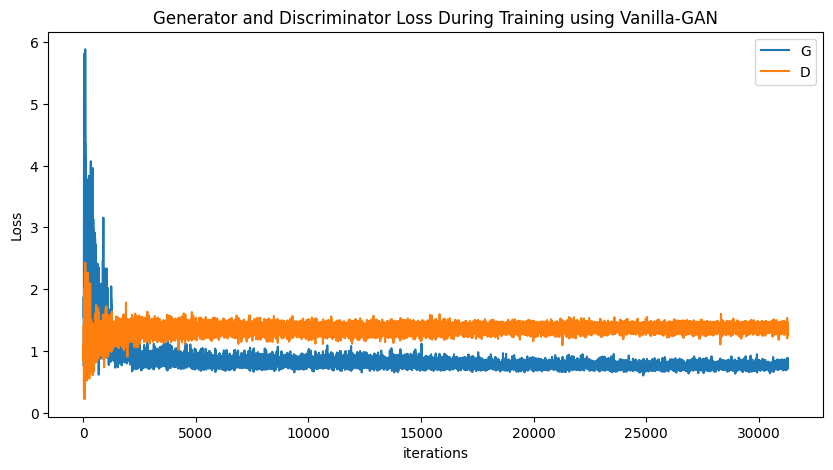

In [ ]:
#plotting loss vs iterations for Vanilla-GAN
plt.figure(figsize=(10,5))  

plt.title("Generator and Discriminator Loss During Training using Vanilla-GAN")    
plt.plot(G_losses,label="G")    
plt.plot(D_losses,label="D") 
plt.xlabel("iterations")   
plt.ylabel("Loss")         
plt.legend()          
plt.savefig('/content/drive/MyDrive/Purdue/SML/gen_and_disc_loss_training_100epoch_bce.png')
plt.show()   

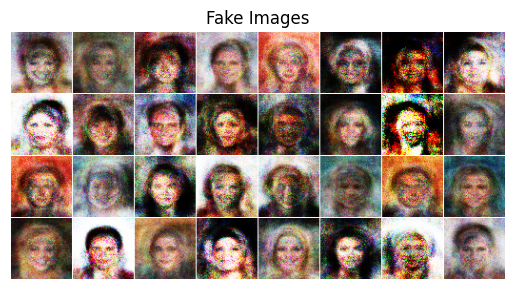

In [ ]:
plt.axis("off")                                                                                
plt.title("Fake Images")                                                                       
plt.imshow(np.transpose(img_list[-1],(1,2,0)))                                                 
plt.savefig('/content/drive/MyDrive/Purdue/SML/fake_images_bceGAN_100epoch.png')                                 
plt.show()  

In [ ]:
!pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchvision.utils import save_image

In [ ]:
#Evaluation for BCE-GAN

# Generate 5004 fake pizza images
num_images = 5004

with torch.no_grad():
    noise = torch.randn(batch_size, 64).to(device)          
    fake_images = GNet(noise)

In [ ]:
#save fake images
print(fake_images.size())
fake_piz_list = []

for i in range(fake_images.shape[0]):
  img = fake_images[i].detach().cpu()
  fake_piz_list.append(img)
  save_image(img,f'/content/drive/MyDrive/Purdue/SML/fakes_gan/fake_img_{i}.png')

torch.Size([32, 3, 64, 64])


In [ ]:
#get paths for fake images generated and evaluation images
fake_piz_paths = []

fake_piz_imgs_path = '/content/drive/MyDrive/Purdue/SML/fakes_gan'
for img_name in os.listdir(fake_piz_imgs_path):
  fake_piz_paths.append(os.path.join(fake_piz_imgs_path,img_name))
print(fake_piz_paths[:5])

real_piz_paths = []

eval_piz_imgs_path = '/content/drive/MyDrive/Purdue/SML/data/test'
for img_name in os.listdir(eval_piz_imgs_path):
  real_piz_paths.append(os.path.join(eval_piz_imgs_path,img_name))
print(real_piz_paths[:5])


['/content/drive/MyDrive/Purdue/SML/fakes_gan/fake_img_0.png', '/content/drive/MyDrive/Purdue/SML/fakes_gan/fake_img_1.png', '/content/drive/MyDrive/Purdue/SML/fakes_gan/fake_img_2.png', '/content/drive/MyDrive/Purdue/SML/fakes_gan/fake_img_3.png', '/content/drive/MyDrive/Purdue/SML/fakes_gan/fake_img_4.png']
['/content/drive/MyDrive/Purdue/SML/data/test/025007.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025012.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025001.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025008.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025015.jpg']


In [ ]:
from pytorch_fid.fid_score import calculate_activation_statistics, calculate_frechet_distance
from pytorch_fid.inception import InceptionV3

In [ ]:
#compute FID score
real_paths = real_piz_paths
fake_paths = fake_piz_paths

dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

model = InceptionV3([block_idx]).to(device)

m1, s1 = calculate_activation_statistics(real_paths, model, device = device)
m2, s2 = calculate_activation_statistics(fake_paths, model, device = device)
fid_value = calculate_frechet_distance (m1 , s1 , m2 , s2)

print ( f'FID using Vanilla-GAN: { fid_value : .2f}')


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 206MB/s]
100%|██████████| 101/101 [01:29<00:00,  1.13it/s]


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


FID using Vanilla-GAN:  347.72


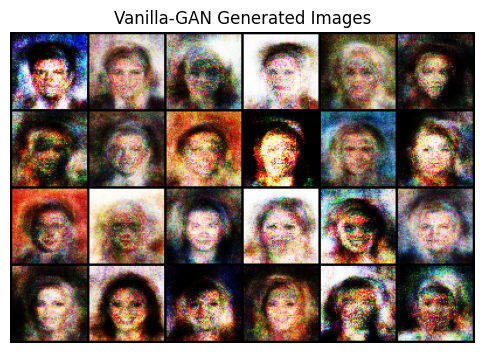

In [ ]:
#plot a sample of 16 fake images generated using BCE-GAN
plot_imgs = fake_images[0:24].detach().cpu()
fig = plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Vanilla-GAN Generated Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(plot_imgs, padding=2, normalize=True, nrow = 6), (1,2,0)))
plt.show()

In [ ]:
#Generator and Discriminator networks (improvised BCE-GAN above to suit scalar output)

class GeneratorNetW(nn.Module):
    def __init__(self):
        super(GeneratorNetW, self).__init__()

        self.conv_transposeN = nn.ConvTranspose2d(100,   512,  kernel_size=4, stride=1, padding=0, bias=False)
        self.conv_transpose1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv_transpose2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv_transpose3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv_transpose4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_normN = nn.BatchNorm2d(512)
        self.batch_norm1 = nn.BatchNorm2d(256)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(64) 

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):

        x = self.relu(self.batch_normN(self.conv_transposeN(z)))#4x4 image
        x = self.relu(self.batch_norm1(self.conv_transpose1(x)))#8x8 image
        x = self.relu(self.batch_norm2(self.conv_transpose2(x)))#16x16 image
        x = self.relu(self.batch_norm3(self.conv_transpose3(x)))#32x32 image
        x = self.tanh(self.conv_transpose4(x))#64x64 image

        return x


class DiscriminatorNetW(nn.Module):
    def __init__(self):
        super(DiscriminatorNetW, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        # self.conv5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)

        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.fc_final = nn.Linear(512*4*4,1)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = self.batch_norm2(self.conv2(x))
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.batch_norm3(self.conv3(x))
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.conv4(x)

        # x = self.conv5(x)
        # print(x.shape)

        x = x.view(-1, 512*4*4)        
        x = self.fc_final(x)
        x = x.mean(0)
        x = x.view(1)
        # print(x.shape)
        return x


In [ ]:
#initialize network and check stats
WGNet = GeneratorNetW()
number_of_learnable_params = sum(p.numel() for p in WGNet.parameters() if p.requires_grad)
num_layers = len(list(WGNet.parameters()))
print("\nThe number of layers in G: %d" % num_layers)
print("\nThe number of learnable parameters in G: %d" % number_of_learnable_params)


The number of layers in G: 13

The number of learnable parameters in G: 3576704


In [ ]:
#initialize network and check stats
WDNet = DiscriminatorNetW()
number_of_learnable_params = sum(p.numel() for p in WDNet.parameters() if p.requires_grad)
num_layers = len(list(WDNet.parameters()))
print("\nThe number of layers in D: %d" % num_layers)
print("\nThe number of learnable parameters in D: %d" % number_of_learnable_params)


The number of layers in D: 16

The number of learnable parameters in D: 2766529


In [ ]:
#check model summary
from torchsummary import summary
WDNet.to(device)

input_tensor = torch.randn(3, 64, 64).to(device)
summary(WDNet, input_tensor.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
            Conv2d-2          [-1, 128, 16, 16]         131,200
       BatchNorm2d-3          [-1, 128, 16, 16]             256
            Conv2d-4            [-1, 256, 8, 8]         524,544
       BatchNorm2d-5            [-1, 256, 8, 8]             512
            Conv2d-6            [-1, 512, 4, 4]       2,097,664
            Linear-7                    [-1, 1]           8,193
Total params: 2,765,505
Trainable params: 2,765,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.31
Params size (MB): 10.55
Estimated Total Size (MB): 11.91
----------------------------------------------------------------


In [ ]:
#Training with W-Net

# Set hyperparameters
lr = 0.0002
epochs = 70
nz_dim = 100
clip_thresh = 0.005

# Initialize generator and discriminator networks
WGNet = WGNet.to(device)
WDNet = WDNet.to(device)

WDNet.apply(weights_init)
WGNet.apply(weights_init)

# Define optimizer for generator and discriminator
optimizer_gW = optim.Adam(WGNet.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_dW = optim.Adam(WDNet.parameters(), lr=lr, betas=(0.5, 0.999))

#fixed noise
fixed_noise = torch.randn(batch_size, nz_dim, 1, 1, device=device)          

#  Establish convention for real and fake labels during training
one = torch.FloatTensor([1]).to(device)
minus_one = torch.FloatTensor([-1]).to(device)

#initialize lists to store results
Wimg_list = []                               
WG_losses = []                               
WD_losses = []   
iters = 0                            
gen_iters = 0   
print("\n\nStarting Training Loop...\n\n") 

# Train the GAN
for epoch in range(epochs):
  data_iter = iter(train_data_loader)

  i = 0
  ncritic = 5

  while i < len(train_data_loader):
    for p in WDNet.parameters():
      p.requires_grad = True          
    if gen_iters < 25 or gen_iters % 500 == 0:    # the choices 25 and 500 are from WGAN
      ncritic = 50
    ic = 0

    #inner while loop        
    while ic < ncritic and i < len(train_data_loader):
      ic += 1
      for p in WDNet.parameters():
        p.data.clamp_(-clip_thresh, clip_thresh) 

      # Train discriminator with real images with traget -1
      optimizer_dW.zero_grad()
      real_images_in_batch = next(data_iter)
      i += 1
      real_images_in_batch =  real_images_in_batch.to(device)
      b_size = real_images_in_batch.size(0)
      # print(real_images_in_batch.size())

      critic_for_reals_mean = WDNet(real_images_in_batch)
      critic_for_reals_mean.backward(minus_one)  

      # Train discriminator with fake images generated by generator with target 1
      noise = torch.randn(b_size, nz_dim, 1, 1, device=device)    
      fakes = WGNet(noise) 
      critic_for_fakes_mean = WDNet(fakes)
      critic_for_fakes_mean.backward(one)

      wasser_dist = critic_for_reals_mean - critic_for_fakes_mean
      loss_critic = critic_for_fakes_mean - critic_for_reals_mean

      ##  Only the Discriminator weights are incremented
      optimizer_dW.step()
    

    # Train generator to fool discriminator
    for p in WDNet.parameters():
      p.requires_grad = False
    optimizer_gW.zero_grad() 
    noise = torch.randn(b_size, nz_dim, 1, 1, device=device)  
    fakes = WGNet(noise) 

    critic_for_fakes_mean = WDNet(fakes)
    loss_gen = critic_for_fakes_mean
    critic_for_fakes_mean.backward(minus_one)

    # Update generator parameters
    optimizer_gW.step()                                                                         
    
    gen_iters += 1

  
    # Print losses at end of each epoch and append losses
    if i % (ncritic * 20) == 0:     
      print ("[ epoch : %d/%d, iter : %5d] loss_critic : %7.4f  loss_gen : %7.4f  wasser_dist : %7.4f" % ((epoch), epochs, (i), loss_critic.data[0], loss_gen.data[0], wasser_dist.data[0]))

    WG_losses.append(loss_gen.data[0].item())                                                                
    WD_losses.append(loss_critic.data[0].item()) 

    #append fake images obtained by generator
    if (iters % 100 == 0) or ((epoch == epochs-1) and (i == len(train_data_loader)-1)):
      with torch.no_grad():
        fake = WGNet(fixed_noise).detach().cpu()
      Wimg_list.append(torchvision.utils.make_grid(fake, padding=1, pad_value=1, normalize=True))
    iters += 1


# Save generator and discriminator models
torch.save(WGNet.state_dict(), "/content/drive/MyDrive/Purdue/SML/generator_wass.pth")
torch.save(WDNet.state_dict(), "/content/drive/MyDrive/Purdue/SML/discriminator_wass.pth")




Starting Training Loop...


[ epoch : 2/70, iter :   100] loss_critic : -2.2270  loss_gen : -0.1375  wasser_dist :  2.2270
[ epoch : 2/70, iter :   200] loss_critic : -2.0924  loss_gen :  0.0193  wasser_dist :  2.0924
[ epoch : 2/70, iter :   300] loss_critic : -1.6749  loss_gen :  0.0383  wasser_dist :  1.6749
[ epoch : 2/70, iter :   400] loss_critic : -1.3336  loss_gen :  0.1954  wasser_dist :  1.3336
[ epoch : 2/70, iter :   500] loss_critic : -1.2509  loss_gen :  0.2725  wasser_dist :  1.2509
[ epoch : 2/70, iter :   600] loss_critic : -1.3233  loss_gen :  0.3950  wasser_dist :  1.3233
[ epoch : 3/70, iter :   100] loss_critic : -1.2068  loss_gen :  0.6082  wasser_dist :  1.2068
[ epoch : 3/70, iter :   200] loss_critic : -1.1721  loss_gen :  0.2880  wasser_dist :  1.1721
[ epoch : 3/70, iter :   300] loss_critic : -1.1536  loss_gen :  0.3180  wasser_dist :  1.1536
[ epoch : 3/70, iter :   400] loss_critic : -1.2884  loss_gen :  0.2058  wasser_dist :  1.2884
[ epoch : 3/70, iter

NameError: ignored

In [ ]:
with open('/content/drive/MyDrive/Purdue/SML/WG_losses.pkl', 'wb') as f:
  pickle.dump(WG_losses, f)

with open('/content/drive/MyDrive/Purdue/SML/WD_losses.pkl', 'wb') as f:
  pickle.dump(WD_losses, f)

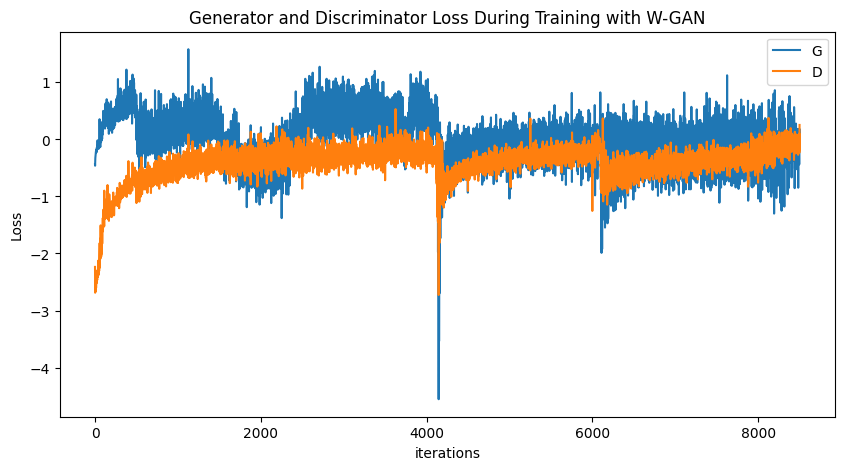

In [ ]:
#plotting loss vs iterations for W-GAN
plt.figure(figsize=(10,5))  

plt.title("Generator and Discriminator Loss During Training with W-GAN")    
plt.plot(WG_losses,label="G")    
plt.plot(WD_losses,label="D") 
plt.xlabel("iterations")   
plt.ylabel("Loss")         
plt.legend()          
plt.savefig('/content/drive/MyDrive/Purdue/SML/gen_and_disc_loss_wgan.png')
plt.show()   

In [ ]:
#Evaluation for W-GAN

# Generate 1,000 fake pizza images
num_images = 5004

with torch.no_grad():
    noise = torch.randn(num_images, nz_dim, 1, 1, device=device)    
    fake_images_WGAN = WGNet(noise)

In [ ]:
#save fake images
print(fake_images_WGAN.size())
fake_piz_list_WGAN = []

for i in range(fake_images_WGAN.shape[0]):
  img = fake_images_WGAN[i].detach().cpu()
  fake_piz_list_WGAN.append(img)
  save_image(img,f'/content/drive/MyDrive/Purdue/SML/fakes_wgan/fake_img_{i}.png')

torch.Size([5004, 3, 64, 64])


In [ ]:
#get paths for fake images generated and evaluation images
fake_piz_paths = []

fake_piz_imgs_path = '/content/drive/MyDrive/Purdue/SML/fakes_wgan'
for img_name in os.listdir(fake_piz_imgs_path):
  fake_piz_paths.append(os.path.join(fake_piz_imgs_path,img_name))
print(fake_piz_paths[:5])

real_piz_paths = []

eval_piz_imgs_path = '/content/drive/MyDrive/Purdue/SML/data/test'
for img_name in os.listdir(eval_piz_imgs_path):
  real_piz_paths.append(os.path.join(eval_piz_imgs_path,img_name))
print(real_piz_paths[:5])

['/content/drive/MyDrive/Purdue/SML/fakes_wgan/fake_img_0.png', '/content/drive/MyDrive/Purdue/SML/fakes_wgan/fake_img_1.png', '/content/drive/MyDrive/Purdue/SML/fakes_wgan/fake_img_2.png', '/content/drive/MyDrive/Purdue/SML/fakes_wgan/fake_img_3.png', '/content/drive/MyDrive/Purdue/SML/fakes_wgan/fake_img_4.png']
['/content/drive/MyDrive/Purdue/SML/data/test/025007.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025012.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025001.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025008.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025015.jpg']


In [ ]:
#compute FID score
real_paths = real_piz_paths
fake_paths = fake_piz_paths

dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

model = InceptionV3([block_idx]).to(device)

m1, s1 = calculate_activation_statistics(real_paths, model, device = device)
m2, s2 = calculate_activation_statistics(fake_paths, model, device = device)
fid_value = calculate_frechet_distance (m1 , s1 , m2 , s2)

print ( f'FID using W-GAN: { fid_value : .2f}')

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 181MB/s]
100%|██████████| 101/101 [00:20<00:00,  4.89it/s]


FID using W-GAN:  218.39


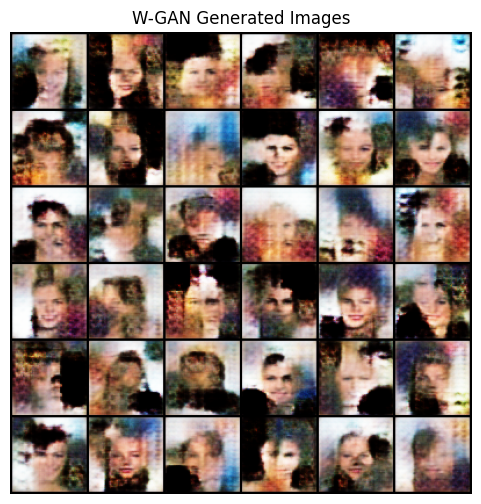

In [ ]:
#plot a sample of 16 fake images generated using W-GAN
plot_imgs = fake_images_WGAN[0:36].detach().cpu()
fig = plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("W-GAN Generated Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(plot_imgs, padding=2, normalize=True, nrow = 6), (1,2,0)))
plt.show()

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            #size = 3*64*64
            nn.Conv2d(channels_img, features_d, kernel_size = 4, stride = 2, padding = 1), # Size : 32*32
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d, features_d*2, kernel_size = 4, stride = 2, padding = 1), # size = 16*16
            nn.InstanceNorm2d(features_d*2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d*2, features_d*4, kernel_size = 4, stride = 2, padding = 1), # size = 8*8
            nn.InstanceNorm2d(features_d*4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d*4, features_d*8, kernel_size = 4, stride = 2, padding = 1), # size = 4*4
            nn.InstanceNorm2d(features_d*8),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d*8, 1, kernel_size = 4, stride = 2, padding = 0) #1*1
            
        )
        
        
    def forward(self, x):
        return self.disc(x)

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g*16, kernel_size = 4, stride = 1, padding = 0), # size = 4*4
            nn.BatchNorm2d(features_g*16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*16, features_g*8, kernel_size = 4, stride = 2, padding = 1), # size = 8*8
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*8, features_g*4, kernel_size = 4, stride = 2, padding = 1), # size = 16*16
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*4, features_g*2, kernel_size = 4, stride = 2, padding = 1), # size = 32*32
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh()  # [-1, 1]
        )
        
    
    def forward(self, x):
        return self.net(x)

In [ ]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

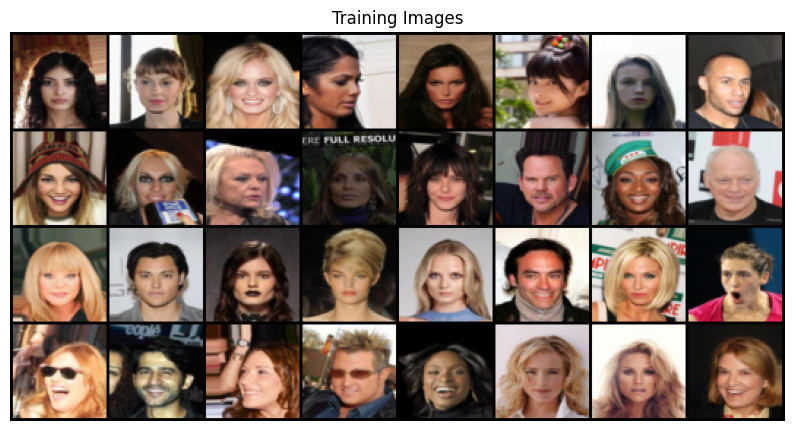

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#plot images of a batch to check dataloader
images = next(iter(train_data_loader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:], padding=2, normalize=True),(1,2,0)));

In [ ]:
def reset_grad():
    opt_disc.zero_grad()
    opt_gen.zero_grad()

In [ ]:
gen = Generator(z_dim = Z_DIM, channels_img = CHANNELS_IMG, features_g = FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas = (0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr = LEARNING_RATE, betas = (0.0, 0.9))

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
    fake_images = gen(z)
    labels = torch.ones(BATCH_SIZE, 1).to(device)
    output = disc(fake_images).reshape(-1)
    g_loss = - torch.mean(output)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    opt_gen.step()
    return g_loss, fake_images

In [ ]:
def train_discriminator(images):
    # create labels, for real image label is 1, for fake 
    
    # loss for real images
    
    for _ in range(CRITIC_ITERATIONS):
        
        # print(images.shape)
        disc_real = disc(images).reshape(-1)
        # print(disc_real.shape)
        real_score = torch.mean(disc_real)
        
        
        z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
        fake_images = gen(z)
        # print(fake_images.shape)

        disc_fake = disc(fake_images).reshape(-1)
        # print(disc_fake.shape)
        fake_score = torch.mean(disc_fake)
        
        gp = gradient_panelty(disc, images, fake_images, device = device)
        
        loss_disc = (
            -(torch.mean(disc_real) - torch.mean(disc_fake)) 
            + LAMBDA_GP * gp )
        
        reset_grad()
        
        loss_disc.backward()
        
        opt_disc.step()
        
        return loss_disc, real_score, fake_score 

In [ ]:
def gradient_panelty(disc, real, fake, device = 'cpu'):
    
    BATCH_SIZE, C, H, W = real.shape
    # print('gp start')
    # print(real.shape)
    # print(fake.shape)
    
    epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).to(device)
    
    interpolated_image = real * epsilon + fake * (1-epsilon)
    
    # Calculate Critic Score
    
    mixed_scores = disc(interpolated_image)
    
    gradient = torch.autograd.grad(
                inputs = interpolated_image,
                outputs = mixed_scores,
                grad_outputs = torch.ones_like(mixed_scores),
                create_graph = True, retain_graph = True
                )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim = 1)
    gradient_panelty = torch.mean((gradient_norm - 1) ** 2)
    
    return gradient_panelty

In [ ]:
sample_vectors = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)

def save_fake_images(index):
    fake_images = gen(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=16)
    
# Before training
save_fake_images(0)

Saving fake_images-0000.png


In [ ]:
len(train_dataloader)

626

In [ ]:
total_step = len(train_dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(NUM_EPOCHS):
    for i, images in enumerate(train_dataloader):
        # Load a batch & transform to vectors
        images = images.to(device)
        bsize = images.size(0)
        # Train the discriminator and generator
        if bsize == 32:
          d_loss, real_score, fake_score = train_discriminator(images)
          g_loss, fake_images = train_generator()
          
          # Inspect the losses
          if (i+1) % 200 == 0:
              d_losses.append(d_loss.item())
              g_losses.append(g_loss.item())
              real_scores.append(real_score.mean().item())
              fake_scores.append(fake_score.mean().item())
              print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                    .format(epoch, NUM_EPOCHS, i+1, total_step, d_loss.item(), g_loss.item(), 
                            real_score.mean().item(), fake_score.mean().item()))
          
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/626], d_loss: -0.5873, g_loss: 11.3902, D(x): -11.14, D(G(z)): -11.87
Epoch [0/50], Step [400/626], d_loss: -0.8468, g_loss: 11.0342, D(x): -9.82, D(G(z)): -10.73
Epoch [0/50], Step [600/626], d_loss: -1.1160, g_loss: 12.8431, D(x): -11.42, D(G(z)): -12.69
Saving fake_images-0001.png
Epoch [1/50], Step [200/626], d_loss: -1.7230, g_loss: 12.0440, D(x): -9.65, D(G(z)): -11.48
Epoch [1/50], Step [400/626], d_loss: -1.3950, g_loss: 11.5532, D(x): -8.84, D(G(z)): -10.32
Epoch [1/50], Step [600/626], d_loss: -0.7895, g_loss: 11.6277, D(x): -9.93, D(G(z)): -10.86
Saving fake_images-0002.png
Epoch [2/50], Step [200/626], d_loss: -0.4302, g_loss: 8.9961, D(x): -7.70, D(G(z)): -8.28
Epoch [2/50], Step [400/626], d_loss: -1.4844, g_loss: 10.3271, D(x): -8.89, D(G(z)): -10.40
Epoch [2/50], Step [600/626], d_loss: -1.1649, g_loss: 9.5752, D(x): -7.41, D(G(z)): -8.70
Saving fake_images-0003.png
Epoch [3/50], Step [200/626], d_loss: -0.9592, g_loss: 7.9281, D(x): -5.49, D(G(z

In [ ]:
def show_img(img, label):
    print('Label: ', label)
    plt.imshow(img.permute(1,2,0), cmap = 'gray')

In [ ]:
def denorm(x):
  out = (x + 1) / 2
  return out.clamp(0, 1)

In [ ]:
sample_dir = '/content/drive/MyDrive/Purdue/SML/wgan_pen'

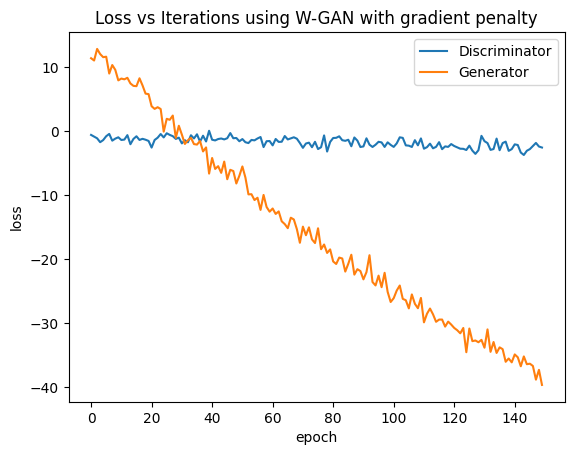

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Loss vs Iterations using W-GAN with gradient penalty');

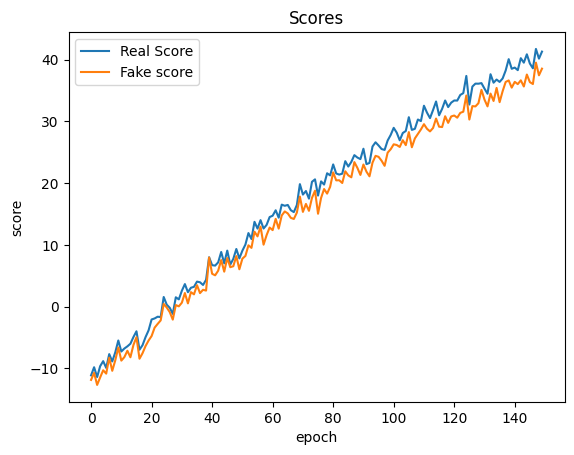

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [ ]:
BATCH_SIZE = 5004
with torch.no_grad():
    z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)

    fake_images = gen(z)

In [ ]:
#save fake images
print(fake_images.size())
fake_piz_list = []

for i in range(fake_images.shape[0]):
  img = fake_images[i].detach().cpu()
  fake_piz_list.append(img)
  save_image(img,f'/content/drive/MyDrive/Purdue/SML/wgan_pen/fake_imgs/fake_img_{i}.png')

torch.Size([5004, 3, 64, 64])


In [ ]:
#get paths for fake images generated and evaluation images
fake_piz_paths = []

fake_piz_imgs_path = '/content/drive/MyDrive/Purdue/SML/wgan_pen/fake_imgs'
for img_name in os.listdir(fake_piz_imgs_path):
  fake_piz_paths.append(os.path.join(fake_piz_imgs_path,img_name))
print(fake_piz_paths[:5])

real_piz_paths = []

eval_piz_imgs_path = '/content/drive/MyDrive/Purdue/SML/data/test'
for img_name in os.listdir(eval_piz_imgs_path):
  real_piz_paths.append(os.path.join(eval_piz_imgs_path,img_name))
print(real_piz_paths[:5])


['/content/drive/MyDrive/Purdue/SML/wgan_pen/fake_imgs/fake_img_0.png', '/content/drive/MyDrive/Purdue/SML/wgan_pen/fake_imgs/fake_img_1.png', '/content/drive/MyDrive/Purdue/SML/wgan_pen/fake_imgs/fake_img_2.png', '/content/drive/MyDrive/Purdue/SML/wgan_pen/fake_imgs/fake_img_3.png', '/content/drive/MyDrive/Purdue/SML/wgan_pen/fake_imgs/fake_img_4.png']
['/content/drive/MyDrive/Purdue/SML/data/test/025007.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025012.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025001.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025008.jpg', '/content/drive/MyDrive/Purdue/SML/data/test/025015.jpg']


In [ ]:
#compute FID score
real_paths = real_piz_paths
fake_paths = fake_piz_paths

dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

model = InceptionV3([block_idx]).to(device)

m1, s1 = calculate_activation_statistics(real_paths, model, device = device)
m2, s2 = calculate_activation_statistics(fake_paths, model, device = device)
fid_value = calculate_frechet_distance (m1 , s1 , m2 , s2)

print ( f'FID using W-GAN with gradient penalty: { fid_value : .2f}')


100%|██████████| 101/101 [00:20<00:00,  4.92it/s]


FID using W-GAN with gradient penalty:  113.28


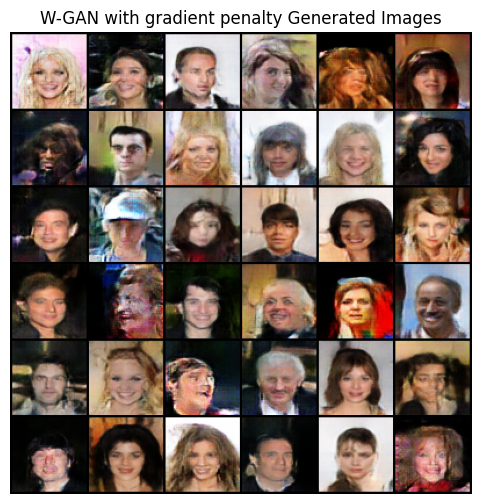

In [ ]:
#plot a sample of 16 fake images generated using BCE-GAN
plot_imgs = fake_images[36+36+36:36+36+36+36].detach().cpu()
fig = plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("W-GAN with gradient penalty Generated Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(plot_imgs, padding=2, normalize=True, nrow = 6), (1,2,0)))
plt.show()